In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prepare_yerevan_data import prepare_yerevan_data_pm_2_5
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [2]:
# In this file we're training a model to predict the pm2.5 level only
air_data = prepare_yerevan_data_pm_2_5()

In [3]:
air_data.head()

,temperature_2m,wind_speed_10m,relative_humidity_2m,precipitation,surface_pressure,is_busy,pm2_5_lag_1h,pm2_5_lag_2h,pm2_5_lag_3h,pm2_5_lag_1d,...,temperature_rolling_3h_mean,temperature_rolling_6h_mean,temperature_rolling_12h_mean,temperature_rolling_24h_mean,pm2_5_rolling_6h_mean,pm2_5_rolling_6h_std,pm2_5_rolling_12h_mean,temp_humidity_2m,temperature_pressure,temp_humidity_rolling_3h
24,-0.4,1.360977,62,0.0,906.0,0,12.0,13.0,14.1,7.8,...,-0.633333,-0.233333,1.083333,1.587500,14.316667,1.594261,13.700000,-24.8,-362.40,-40.733333
25,0.2,1.193922,58,0.0,907.4,0,10.8,12.0,13.0,7.7,...,-0.433333,-0.583333,0.575000,1.570833,13.433333,1.855442,13.658333,11.6,181.48,-27.333333
26,-2.1,1.609438,67,0.0,906.4,0,10.0,10.8,12.0,7.1,...,-0.100000,-0.466667,0.250000,1.583333,12.483333,1.920851,13.483333,-140.7,-1903.44,-6.400000
27,-1.4,1.629241,62,0.0,906.4,0,9.5,10.0,10.8,6.8,...,-0.766667,-0.700000,0.016667,1.454167,11.566667,1.787363,13.275000,-86.8,-1268.96,-51.300000
28,-2.1,1.589235,66,0.0,905.9,0,8.9,9.5,10.0,5.7,...,-1.100000,-0.766667,-0.075000,1.387500,10.700000,1.559487,12.933333,-138.6,-1902.39,-71.966667


(array([2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00,
        2.000e+00, 1.100e+01, 1.500e+01, 4.200e+01, 1.030e+02, 1.940e+02,
        4.370e+02, 9.520e+02, 2.389e+03, 8.091e+03, 4.005e+03, 1.240e+03,
        5.240e+02, 2.380e+02, 1.370e+02, 8.100e+01, 3.500e+01, 1.800e+01,
        1.600e+01, 7.000e+00, 4.000e+00, 2.000e+00, 1.000e+00, 1.000e+00]),
 array([-11.2       , -10.48666667,  -9.77333333,  -9.06      ,
         -8.34666667,  -7.63333333,  -6.92      ,  -6.20666667,
         -5.49333333,  -4.78      ,  -4.06666667,  -3.35333333,
         -2.64      ,  -1.92666667,  -1.21333333,  -0.5       ,
          0.21333333,   0.92666667,   1.64      ,   2.35333333,
          3.06666667,   3.78      ,   4.49333333,   5.20666667,
          5.92      ,   6.63333333,   7.34666667,   8.06      ,
          8.77333333,   9.48666667,  10.2       ]),
 <BarContainer object of 30 artists>)

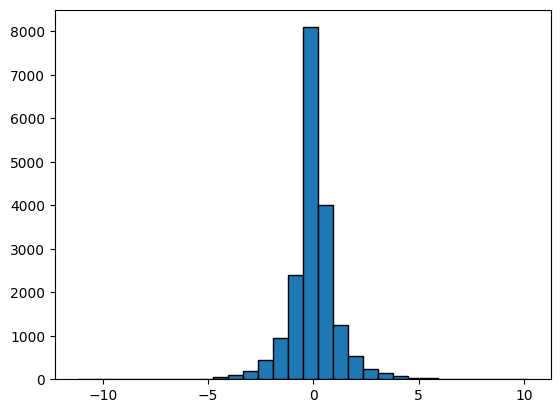

In [4]:
plt.hist(air_data['pm2_5_delta'], bins=30, edgecolor='k')

In [5]:
corr_matrix = air_data.corr()
print(corr_matrix["pm2_5_delta"].sort_values(ascending=False))

pm2_5_delta                     1.000000
is_busy                         0.283718
surface_pressure                0.031864
temp_humidity_rolling_3h        0.031360
temp_humidity_2m                0.027168
temperature_pressure            0.018032
temperature_2m                  0.017811
temperature_rolling_6h_mean     0.014253
temperature_rolling_12h_mean    0.011253
wind_speed_10m                  0.008254
temperature_rolling_3h_mean     0.006731
wind_speed_lag_1h              -0.000144
pm2_5_lag_1d                   -0.000490
temperature_rolling_24h_mean   -0.002200
precipitation                  -0.010716
relative_humidity_2m           -0.012006
wind_speed_lag_2h              -0.012628
stagnation                     -0.012995
wind_speed_lag_3h              -0.045814
hour_sin                       -0.087600
pm2_5_lag_1h                   -0.100630
pm2_5_rolling_12h_mean         -0.151383
hour_cos                       -0.154515
pm2_5_rolling_6h_std           -0.160930
pm2_5_lag_2h    

In [6]:
# Splitting into training and testing
y = air_data['pm2_5_delta']
X = air_data.drop(columns=['pm2_5_delta'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, shuffle=False)

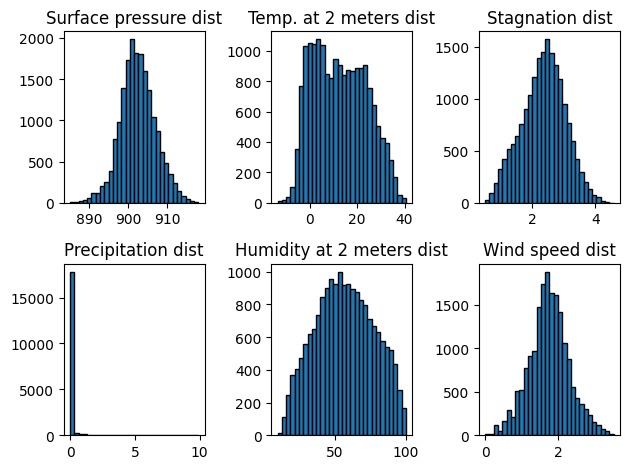

In [7]:
fig, axs = plt.subplots(2, 3)

axs[0, 0].hist(air_data['surface_pressure'], bins=30, edgecolor='k')
axs[0, 0].set_title("Surface pressure dist")
axs[0, 1].hist(air_data['temperature_2m'], bins=30, edgecolor='k')
axs[0, 1].set_title("Temp. at 2 meters dist")
axs[0, 2].hist(air_data['stagnation'], bins=30, edgecolor='k')
axs[0, 2].set_title("Stagnation dist")
axs[1, 0].hist(air_data['precipitation'], bins=30, edgecolor='k')
axs[1, 0].set_title("Precipitation dist")
axs[1, 1].hist(air_data['relative_humidity_2m'], bins=30, edgecolor='k')
axs[1, 1].set_title("Humidity at 2 meters dist")
axs[1, 2].hist(air_data['wind_speed_10m'], bins=30, edgecolor='k')
axs[1, 2].set_title("Wind speed dist")
plt.tight_layout()
plt.show()

In [8]:
# Selecting a model and fitting (hyperparams are tuned by performing grid search)
model = XGBRegressor(
    random_state=42,
    gamma=0.1,
    learning_rate=0.01,
    n_estimators=1000,
    max_depth=5,
)

In [9]:
# Fit the model
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [10]:
# Predicting
y_pred = model.predict(X_test)

In [11]:
# Evaluating
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"RMSE: {root_mean_squared_error(y_test, y_pred):.3f}")
print(f"R^2: {r2_score(y_test, y_pred):.3f}")

MAE: 0.747
RMSE: 1.102
R^2: 0.410


In [12]:
# Feature importances for the model
importances = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

                         Feature  Importance
5                        is_busy    0.236086
24          temperature_pressure    0.173420
23              temp_humidity_2m    0.073202
8                   pm2_5_lag_3h    0.066456
19  temperature_rolling_24h_mean    0.054825
10                      hour_sin    0.042831
11                      hour_cos    0.040250
7                   pm2_5_lag_2h    0.024476
17   temperature_rolling_6h_mean    0.023948
18  temperature_rolling_12h_mean    0.022788
20         pm2_5_rolling_6h_mean    0.021059
21          pm2_5_rolling_6h_std    0.020152
6                   pm2_5_lag_1h    0.020017
22        pm2_5_rolling_12h_mean    0.019828
9                   pm2_5_lag_1d    0.019532
16   temperature_rolling_3h_mean    0.018319
25      temp_humidity_rolling_3h    0.016309
15             wind_speed_lag_3h    0.016192
13             wind_speed_lag_1h    0.015341
14             wind_speed_lag_2h    0.012148
4               surface_pressure    0.012045
0         